# 03 - MODELO k-NN (K-NEAREST NEIGHBORS)

Modelo no paramétrico para clasificación binaria de fraude.
Incluye búsqueda de hiperparámetros, validación cruzada y evaluación completa.

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc,
    balanced_accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Cargar Datos Preprocesados

In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"\nFraude en train: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"Fraude en test: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.2f}%)")

X_train: (16000, 13)
X_test: (4000, 13)
y_train: (16000,)
y_test: (4000,)

Fraude en train: 160 (1.00%)
Fraude en test: 40 (1.00%)


## Balanceo de Clases con SMOTE


In [3]:
print("Distribución en Train antes de SMOTE:")
print(y_train.value_counts())

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar resample solo al conjunto de entrenamiento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribución en Train después de SMOTE:")
print(y_train_balanced.value_counts())

# Reemplazar las variables de entrenamiento
X_train = X_train_balanced
y_train = y_train_balanced

Distribución en Train antes de SMOTE:
isFraud
0    15840
1      160
Name: count, dtype: int64

Distribución en Train después de SMOTE:
isFraud
0    15840
1    15840
Name: count, dtype: int64


## Configuración Experimental - Malla de Hiperparámetros

In [5]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

print("Malla de Hiperparámetros para k-NN:")
print(f"n_neighbors: {param_grid['n_neighbors']}")
print(f"metric: {param_grid['metric']}")
print(f"weights: {param_grid['weights']}")
print(f"\nTotal de combinaciones: {len(param_grid['n_neighbors']) * len(param_grid['metric']) * len(param_grid['weights'])}")

Malla de Hiperparámetros para k-NN:
n_neighbors: [3, 5, 7, 9, 11, 15, 21]
metric: ['euclidean', 'manhattan', 'minkowski']
weights: ['uniform', 'distance']

Total de combinaciones: 42


## Metodología de Validación

In [6]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'balanced_accuracy': 'balanced_accuracy'
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring=scoring,
    refit='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV configurado con:")
print(f"- Validación cruzada: 5-fold estratificada")
print(f"- Métrica de selección: Balanced Accuracy")
print(f"- Otras métricas evaluadas: {list(scoring.keys())}")

GridSearchCV configurado con:
- Validación cruzada: 5-fold estratificada
- Métrica de selección: Balanced Accuracy
- Otras métricas evaluadas: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'balanced_accuracy']


## Búsqueda de Hiperparámetros

In [7]:
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor Balanced Accuracy (CV): {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Mejor Balanced Accuracy (CV): 0.9857


## Resultados de Validación Cruzada

In [8]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_balanced_accuracy')

top_10 = cv_results[[
    'param_n_neighbors', 'param_metric', 'param_weights',
    'mean_test_balanced_accuracy', 'std_test_balanced_accuracy',
    'mean_test_f1', 'mean_test_recall', 'mean_test_precision'
]].head(15)

print("mejores 10 configuraciones (validación cruzada):")
print(top_10.to_string())

mejores 10 configuraciones (validación cruzada):
    param_n_neighbors param_metric param_weights  mean_test_balanced_accuracy  std_test_balanced_accuracy  mean_test_f1  mean_test_recall  mean_test_precision
15                  3    manhattan      distance                     0.985669                    0.001153      0.985870          0.999811             0.972316
14                  3    manhattan       uniform                     0.985259                    0.001123      0.985468          0.999558             0.971772
1                   3    euclidean      distance                     0.983586                    0.001954      0.983852          0.999874             0.968343
29                  3    minkowski      distance                     0.983586                    0.001954      0.983852          0.999874             0.968343
28                  3    minkowski       uniform                     0.983081                    0.001770      0.983358          0.999558             0.9676

## Evaluación en Entrenamiento, Validación y Test del mejor modelo encontrado

In [9]:
best_model = grid_search.best_estimator_

# Predicciones en Train
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predicciones en Test
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Predicciones con validación cruzada (para intervalo de confianza)
y_val_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
y_val_pred_proba = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

## Cálculo de Métricas con Intervalos de Confianza

In [10]:
def compute_metrics_with_ci(y_true, y_pred, y_proba, set_name=''):
    metrics = {}

    # Balanced Accuracy
    ba = balanced_accuracy_score(y_true, y_pred)

    # Precision
    prec = precision_score(y_true, y_pred, zero_division=0)

    # Recall
    rec = recall_score(y_true, y_pred, zero_division=0)

    # F1-Score
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_proba)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Intervalo de confianza (95%) usando bootstrap
    n_bootstrap = 1000
    ba_bootstrap = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        ba_bootstrap.append(balanced_accuracy_score(y_true.iloc[idx], y_pred[idx]))

    ba_ci = np.percentile(ba_bootstrap, [2.5, 97.5])

    return {
        'Balanced Accuracy': f"{ba:.4f} [{ba_ci[0]:.4f}, {ba_ci[1]:.4f}]",
        'Precision': f"{prec:.4f}",
        'Recall': f"{rec:.4f}",
        'F1-Score': f"{f1:.4f}",
        'AUC-ROC': f"{auc_roc:.4f}",
        'Accuracy': f"{acc:.4f}"
    }

metrics_train = compute_metrics_with_ci(y_train, y_train_pred, y_train_pred_proba, 'Train')
metrics_val = compute_metrics_with_ci(y_train, y_val_pred, y_val_pred_proba, 'Validación')
metrics_test = compute_metrics_with_ci(y_test, y_test_pred, y_test_pred_proba, 'Test')

results_df = pd.DataFrame({
    'Train': metrics_train,
    'Validación (CV)': metrics_val,
    'Test': metrics_test
})

print("RESULTADOS DEL MODELO")
print(results_df.to_string())

RESULTADOS DEL MODELO
                                     Train          Validación (CV)                     Test
Balanced Accuracy  1.0000 [1.0000, 1.0000]  0.9857 [0.9844, 0.9869]  0.7494 [0.6744, 0.8255]
Precision                           1.0000                   0.9723                   0.1680
Recall                              1.0000                   0.9998                   0.5250
F1-Score                            1.0000                   0.9859                   0.2545
AUC-ROC                             1.0000                   0.9925                   0.7629
Accuracy                            1.0000                   0.9857                   0.9692


## Matriz de Confusión

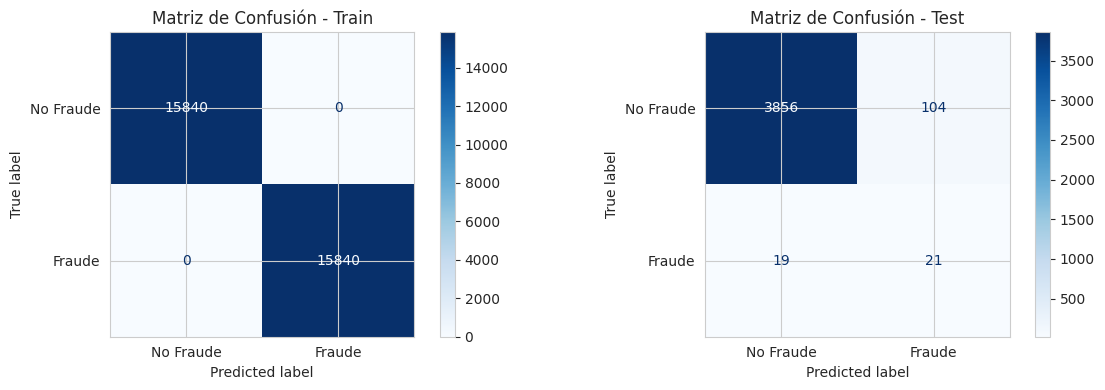

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=['No Fraude', 'Fraude']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Matriz de Confusión - Train')

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=['No Fraude', 'Fraude']).plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Matriz de Confusión - Test')

plt.tight_layout()
plt.savefig('knn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Curva ROC

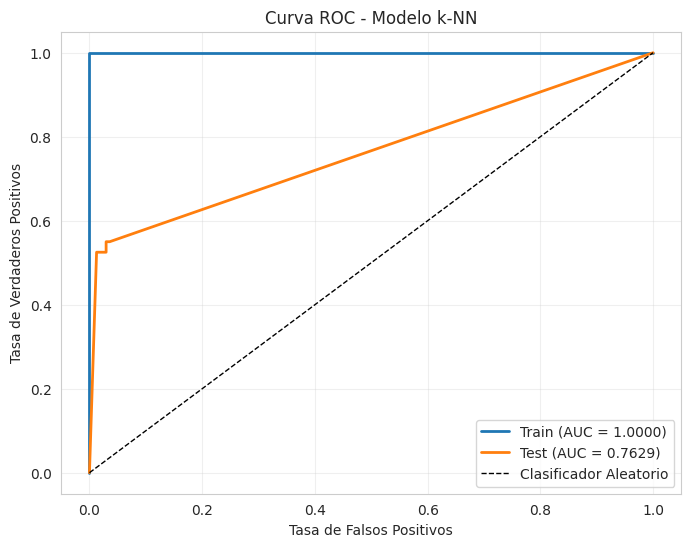

In [12]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo k-NN')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('knn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## Efecto de Hiperparámetros

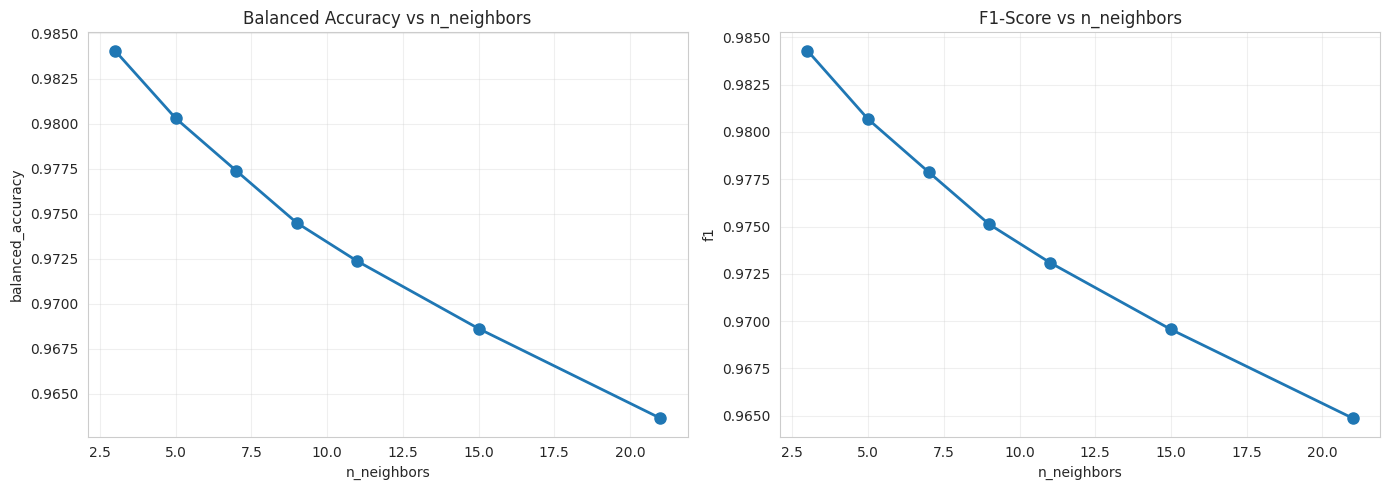

In [13]:
# Análisis del efecto de n_neighbors
cv_results_sorted = cv_results.sort_values('param_n_neighbors')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Efecto de n_neighbors
for metric_col in ['mean_test_balanced_accuracy', 'mean_test_f1']:
    if metric_col == 'mean_test_balanced_accuracy':
        ax = axes[0]
        title = 'Balanced Accuracy vs n_neighbors'
    else:
        ax = axes[1]
        title = 'F1-Score vs n_neighbors'

    n_neighbors_vals = cv_results_sorted['param_n_neighbors'].unique()
    means = [cv_results_sorted[cv_results_sorted['param_n_neighbors'] == k][metric_col].mean()
             for k in n_neighbors_vals]

    ax.plot(n_neighbors_vals, means, marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('n_neighbors')
    ax.set_ylabel(metric_col.replace('mean_test_', ''))
    ax.set_title(title)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('knn_hyperparameter_effect.png', dpi=300, bbox_inches='tight')
plt.show()